In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from fiona.crs import from_epsg

from glob import glob

import re, json

%matplotlib inline

In [2]:
method_full = {"axis_ratio" : "Axis Ratio", "dist_a" : "Areal Distance", "dist_p" : "Population Distance",
               "dyn_radius" : "Dynamic Radius", "ehrenburg" : "Inscribed Circles", "exchange" : "Exchange", 
               "harm_radius" : "Harmonic Radius", "hull_a" : "Hull Area", "hull_p" : "Hull Population", 
               "inertia_a" : "Inertia Area", "inertia_p" : "Inertia Population", "mean_radius" : "Mean Radius", 
               "polsby" : "Isoperimeter Quotient", "polsby_w" : "County-Weighted IPQ",
               "power" : "Power Diagram", "reock" : "Circumscribing Circles", 
               "rohrbach" : "Distance to Perimeter", "split" : "Split-Line", "path_frac" : "Path Fraction",
               "107" : "107th Congress", "111" : "111th Congress", "114" : "114th Congress"}

states_full = {"PA" : "Pennsylvania", "LA" : "Lousiana", "NC" : "North Carolina", "WI" : "Wisconsin", 
               "VA" : "Virginia", "FL" : "Florida", "IL" : "Illinois", "MD" : "Maryland", 
               "MN" : "Minnesota", "TN" : "Tennessee", "TX" : "Texas"}

In [3]:
usps = "nc"

In [4]:
gidx = gpd.read_postgis("SELECT county, tract, pop, geomsimp "
                       "FROM census_tracts_2015 tr JOIN states s on tr.state = s.fips "
                       "WHERE usps = UPPER('{}') ORDER BY county, tract;".format(usps), 
                       geom_col = "geomsimp", crs = from_epsg(2163), con = cen_con).to_crs(epsg = 3364)

gidx["index"] = gidx.index

In [5]:
data = pd.read_csv("/media/jsaxon/brobdingnag/data/s3/res/{}/power/s300/c000/final.csv".format(usps), 
                   names = ["index", "cd"])

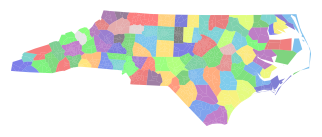

In [6]:
map_format(gidx.merge(data).plot("county", cmap = "nipy_spectral", alpha = 0.5, figsize = (2, 2)));

In [7]:
def cd_share(usps, sessn):
    
    table = "census_blocks_2010"
    geom  = "geom"
    if int(sessn) == 111:
        table = "census_blocks_2000"
    if int(sessn) == 107:
        table = "census_bg_2010"
        geom  = "centroid"

    cd = pd.read_sql("SELECT county, cd, pop "
                     "FROM {} b "
                     "JOIN cd ON "
                     "  b.state = cd.state AND "
                     "  ST_Within(b.{}, cd.geom) "
                     "JOIN states s ON "
                     "  b.state = s.fips "
                     "WHERE usps = UPPER('{}') AND sessn = {};".format(table, geom, usps, sessn), 
                     con = cen_con)

    cd_sum        = cd.groupby("cd")            ["pop"].sum().reset_index().rename(columns = {"pop" : "cd_pop"})
    county_sum    = cd.groupby("county")        ["pop"].sum().reset_index().rename(columns = {"pop" : "county_pop"})
    cd_county_sum = cd.groupby(["cd", "county"])["pop"].sum().reset_index().rename(columns = {"pop" : "cd_county_pop"})

    splits = cd_county_sum.merge(cd_sum).merge(county_sum)
    splits["Xpop"] = splits[["county_pop", "cd_pop"]].min(axis = 1)
    splits["frac"] = splits["cd_county_pop"] / splits["Xpop"]

    s = (splits.frac * splits["cd_county_pop"]).sum() / splits["cd_county_pop"].sum()

    return [s]


In [8]:
def split_rate(f, idx):

    data = pd.read_csv(f, names = ["index", "cd"])

    data = idx.merge(data)[["index", "cd", "county", "pop"]]

    cd_sum        = data.groupby("cd")            ["pop"].sum().reset_index().rename(columns = {"pop" : "cd_pop"})
    county_sum    = data.groupby("county")        ["pop"].sum().reset_index().rename(columns = {"pop" : "county_pop"})
    cd_county_sum = data.groupby(["cd", "county"])["pop"].sum().reset_index().rename(columns = {"pop" : "cd_county_pop"})

    splits = cd_county_sum.merge(cd_sum).merge(county_sum)
    splits["Xpop"] = splits[["county_pop", "cd_pop"]].min(axis = 1)
    splits["frac"] = splits["cd_county_pop"] / splits["Xpop"]

    sval = (splits.frac * splits["cd_county_pop"]).sum() / splits["cd_county_pop"].sum()

    return sval

In [9]:
jdir = "/media/jsaxon/brobdingnag/data/c4_redux/"
s3_files = "/media/jsaxon/brobdingnag/data/s3/res/{}/final.csv"
polsby_w_files = "/home/jsaxon/proj/cluscious/res/{}/polsby_w/s*/*/final.csv"

def get_state_files(s):

    files = {}
    
    with open(jdir + "/{}_redux.json".format(s.lower())) as fi:
        for line in fi:

            j = json.loads(line)

            m = j["UID"].split("/")[1]

            if "TX" in s:
                if m == "axis_ratio":
                    if j["PopulationDeviation"] > 0.10: continue
                elif j["PopulationDeviation"] > 0.05: continue
            elif m == "axis_ratio":
                if j["PopulationDeviation"] > 0.05: continue
            elif j["PopulationDeviation"] > 0.021: continue

            if m not in files: files[m] = []

            files[m].append(s3_files.format(j["UID"]))

    files["polsby_w"] = list(glob(polsby_w_files.format(s)))
        
    return files


In [10]:
import seaborn as sns
sns.set_context("notebook", font_scale = 1.5)
sns.set_style("white", rc={"figure.figsize": (2.5, 0.5), "axes.linewidth" : 2})

size = (2.2, 0.5)
bins = np.arange(0, 1.001, 0.01)
def plot_common_county(data, state, method, vmin, vmax):

    # sns.set(rc={"figure.figsize": size, "axes.linewidth" : 4})
    f, ax = plt.subplots(1, sharex=True, sharey=True, figsize = size)


    if len(data) > 1:

        sns.distplot(data, ax = ax, bins = bins,
                     norm_hist = True, kde = False, 
                     hist_kws={"alpha" : 1.0, "color" : "#4DAFFF"})

    if len(data):

        mval = sum(data) / len(data)
        ax.plot([mval, mval], ax.get_ylim(), 
                linewidth = 3, linestyle = "solid", 
                c = "r" if method[0] == "1" else "k")


    sns.despine(left = True)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_xlim(vmin, vmax)
    
    f.savefig("figs/splits/{}_{}_ax.pdf".format(state, method), bbox_inches='tight', pad_inches=0)

    ax.set_xticks([])
    f.savefig("figs/splits/{}_{}.pdf".format(state, method), bbox_inches='tight', pad_inches=0)

    plt.close("all")


In [11]:
vmin = {"md" : 0.53, "nc" : 0.65, "pa" : 0.55}
vmax = {"md" : 0.81, "nc" : 0.88, "pa" : 0.88}

communities_df = []
for s in ["md", "nc", "pa"]:

    idx = pd.read_sql("SELECT county, tract, pop FROM census_tracts_2015 tr "
                      "JOIN states s ON s.fips = tr.state WHERE usps = UPPER('{}') "
                      "ORDER BY county, tract".format(s), con = cen_con)
    
    idx["index"] = idx.index
    
    csv_files = get_state_files(s)
    
    print(s, end = " :: ")
    communities = []
    community_data = {}
    for m in sorted(method_full):
    
        print(m, end = " ")
        if "1" in m: shares = cd_share(s, m)
        else: 
            shares = [split_rate(f, idx) for f in csv_files[m]]
            
        communities.append([m, sum(shares) / len(shares),
                            "XZfigs/splits/{}_{}ZX".format(s.lower(), m)])
        
        community_data[m] = shares
        
    for m, data in community_data.items():
        plot_common_county(data, s, m, vmin[s], vmax[s])
                
    print()

    cdf = pd.DataFrame(communities, columns = ["Method", "Mean", "Figure"])
    cdf.replace({"Method" : method_full}, inplace = True)
    cdf.set_index(["Method"], inplace = True)
        
    communities_df.append(cdf)
    
pd.options.display.precision = 2
cdf = pd.concat(communities_df, axis = 1)
cdf.columns = pd.MultiIndex.from_product([["Maryland", "North Carolina", "Pennsylvania"],
                                          ["Mean", "Figure"]])

cdf

md :: 107 111 114 axis_ratio dist_a dist_p dyn_radius ehrenburg exchange harm_radius hull_a hull_p inertia_a inertia_p mean_radius path_frac polsby polsby_w power reock rohrbach split 
nc :: 107 111 114 axis_ratio dist_a dist_p dyn_radius ehrenburg exchange harm_radius hull_a hull_p inertia_a inertia_p mean_radius path_frac polsby polsby_w power reock rohrbach split 
pa :: 107 111 114 axis_ratio dist_a dist_p dyn_radius ehrenburg exchange harm_radius hull_a hull_p inertia_a inertia_p mean_radius path_frac polsby polsby_w power reock rohrbach split 


Maryland                                  \
                           Mean                          Figure   
Method                                                            
107th Congress             0.71          XZfigs/splits/md_107ZX   
111th Congress             0.62          XZfigs/splits/md_111ZX   
114th Congress             0.58          XZfigs/splits/md_114ZX   
Axis Ratio                 0.67   XZfigs/splits/md_axis_ratioZX   
Areal Distance             0.70       XZfigs/splits/md_dist_aZX   
Population Distance        0.70       XZfigs/splits/md_dist_pZX   
Dynamic Radius             0.69   XZfigs/splits/md_dyn_radiusZX   
Inscribed Circles          0.67    XZfigs/splits/md_ehrenburgZX   
Exchange                   0.68     XZfigs/splits/md_exchangeZX   
Harmonic Radius            0.68  XZfigs/splits/md_harm_radiusZX   
Hull Area                  0.68       XZfigs/splits/md_hull_aZX   
Hull Population            0.66       XZfigs/splits/md_hull_pZX   
Inertia Area               0.69    XZfigs/splits/md_inertia_aZX   
Inertia Population         0.70    XZfigs/splits/md_inertia_pZX   
Mean Radius                0.69  XZfigs/splits/md_mean_radiusZX   
Path Fraction              0.62    XZfigs/splits/md_path_fracZX   
Isoperimeter Quotient      0.66       XZfigs/splits/md_polsbyZX   
County-Weighted IPQ        0.69     XZfigs/splits/md_polsby_wZX   
Power Diagram              0.69        XZfigs/splits/md_powerZX   
Circumscribing Circles     0.68        XZfigs/splits/md_reockZX   
Distance to Perimeter      0.67     XZfigs/splits/md_rohrbachZX   
Split-Line                 0.71        XZfigs/splits/md_splitZX   

                       North Carolina                                  \
                                 Mean                          Figure   
Method                                                                  
107th Congress                   0.79          XZfigs/splits/nc_107ZX   
111th Congress                   0.73          XZfigs/splits/nc_111ZX   
114th Congress                   0.71          XZfigs/splits/nc_114ZX   
Axis Ratio                       0.74   XZfigs/splits/nc_axis_ratioZX   
Areal Distance                   0.78       XZfigs/splits/nc_dist_aZX   
Population Distance              0.80       XZfigs/splits/nc_dist_pZX   
Dynamic Radius                   0.78   XZfigs/splits/nc_dyn_radiusZX   
Inscribed Circles                0.76    XZfigs/splits/nc_ehrenburgZX   
Exchange                         0.77     XZfigs/splits/nc_exchangeZX   
Harmonic Radius                  0.79  XZfigs/splits/nc_harm_radiusZX   
Hull Area                        0.76       XZfigs/splits/nc_hull_aZX   
Hull Population                  0.74       XZfigs/splits/nc_hull_pZX   
Inertia Area                     0.78    XZfigs/splits/nc_inertia_aZX   
Inertia Population               0.78    XZfigs/splits/nc_inertia_pZX   
Mean Radius                      0.78  XZfigs/splits/nc_mean_radiusZX   
Path Fraction                    0.73    XZfigs/splits/nc_path_fracZX   
Isoperimeter Quotient            0.77       XZfigs/splits/nc_polsbyZX   
County-Weighted IPQ              0.81     XZfigs/splits/nc_polsby_wZX   
Power Diagram                    0.78        XZfigs/splits/nc_powerZX   
Circumscribing Circles           0.77        XZfigs/splits/nc_reockZX   
Distance to Perimeter            0.75     XZfigs/splits/nc_rohrbachZX   
Split-Line                       0.77        XZfigs/splits/nc_splitZX   

                       Pennsylvania                                  
                               Mean                          Figure  
Method                                                               
107th Congress                 0.87          XZfigs/splits/pa_107ZX  
111th Congress                 0.77          XZfigs/splits/pa_111ZX  
114th Congress                 0.72          XZfigs/splits/pa_114ZX  
Axis Ratio                     0.69   XZfigs/splits/pa_axis_ratioZX  
Areal Distance                 

In [12]:
cdf.sort_index(inplace = True)
tex = cdf.to_latex(na_rep = "", column_format = "l" + "c" * 6,
                                multicolumn_format = "c")

caption = """
Probability of a citizen of a county living in the same congressional district
  as another randomly-selected citizen of their county, for distributions of maps
  derived for various compactness definitions.
The ``probability" is modified to account for counties larger than
  Congressional Districts (see text).
North Carolina gained a seat after the 2000 Census, 
  whereas Pennsylvania lost seats in both 2002 and 2012.
The probabilities do not not correct for this effect (first three rows).
There is a progression towards more-dividied counties
  among the enacted maps.
For Maryland and North Carolina, the automated procedures 
  outperform the enacted maps.
The county-weighted isoperimeter quotient measure outperforms 
  baseline IPQ by a few percent.
"""


tex = re.sub(r" *(Maryland) \& *", r" \multicolumn{2}{c}{ \selectfont \1} ", tex)
tex = re.sub(r" *(North Carolina) \& *", r" \multicolumn{2}{c}{ \selectfont \1} ", tex)
tex = re.sub(r" *(Pennsylvania) \& *", r" \multicolumn{2}{c}{ \selectfont \1} ", tex)

tex = re.sub(r".*Mean.*\n", "", tex)
tex = re.sub(r".*Method.*\n", "", tex)

tex = tex.replace("splitZX", "split_axZX")

tex = tex.replace("XZ", "\includegraphics[width=6.5em]{")
tex = tex.replace("\_", "_")
tex = tex.replace("ZX", "}")

# tex = tex.replace("nan", "")
tex = re.sub("None", "\includegraphics[width=6.5em]{mini_hist/blank}", tex)

tex = tex.replace("toprule", "hline \\hline \\\\ ")
tex = tex.replace("\midrule", "\\\\ \\hline \\\\")
tex = tex.replace("\\bottomrule", "\hline \hline")

tex = tex + "\caption{" + caption + "}"
tex = tex + "\label{tab:competitiveness}"

tex = "\n\\begin{table}\n\\renewcommand{\\arraystretch}{0.7}\n " + tex + "\n\\end{table}\n "

tex = tex.replace("figs/", "")

tex = tex.replace("Areal Distance", "\\\\ \hline \\\\ \nAreal Distance")

tex = re.sub(r"(Split-Line)(.*)(0.[0-9]{2})(.*)(0.[0-9]{2})(.*)(0.[0-9]{2})", 
             r"\\raisebox{1.3em}{\1} \2 \\raisebox{1.3em}{\3} \4 \\raisebox{1.3em}{\5} \6 \\raisebox{1.3em}{\7} ", tex)

tex = "^NT:\n\n" + tex

with open("tex/splits_table.tex", "w") as o: o.write(tex)

In [13]:
# gidx[["index", "geomsimp"]].merge(splits[["index", "frac"]]).plot("frac", legend = True)